# <center> Homework 3 </center>

&copy; 2023 Kaiwen Zhou

In [33]:
# To support both python 2 and python 3
from __future__ import division, print_function, unicode_literals

# Common imports
import numpy as np
import os

# to make this notebook's output stable across runs
np.random.seed(42)

# To plot pretty figures
%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

In [34]:
# a few auxiliary plotting functions for the MNIST dataset below
def plot_digit(data):
    image = data.reshape(28, 28)
    plt.imshow(image, cmap = matplotlib.cm.binary,
               interpolation="nearest")
    plt.axis("off")
    
# EXTRA
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    images = [instance.reshape(size,size) for instance in instances]
    n_rows = (len(instances) - 1) // images_per_row + 1
    row_images = []
    n_empty = n_rows * images_per_row - len(instances)
    images.append(np.zeros((size, size * n_empty)))
    for row in range(n_rows):
        rimages = images[row * images_per_row : (row + 1) * images_per_row]
        row_images.append(np.concatenate(rimages, axis=1))
    image = np.concatenate(row_images, axis=0)
    plt.imshow(image, cmap = matplotlib.cm.binary, **options)
    plt.axis("off")

# MINST DATA

In [35]:
import warnings
warnings.filterwarnings('ignore') 

In [36]:
import sklearn as skl
import pickle

try:
    print('trying loading pre-saved mnist data')
    with open('mnist.pkl', 'rb') as file:
        mnist = pickle.load(file)
        print('done')
except:
    print('failed loading pre-saved mnist... loading from repository')
    if skl.__version__ >= '0.22':
        from sklearn.datasets import fetch_openml
        mnist = fetch_openml('mnist_784', as_frame=False)    
    else:
        from sklearn.datasets import fetch_mldata
        mnist = fetch_mldata('MNIST original') # Depreciated in newer versions of sklearn
    
    print('saving locally')
    with open('mnist.pkl', 'wb') as file:
        pickle.dump(mnist, file)

# Data, Label
mnist.data, mnist.target

trying loading pre-saved mnist data
done


(array([[0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        ...,
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.],
        [0., 0., 0., ..., 0., 0., 0.]]),
 array(['5', '0', '4', ..., '4', '5', '6'], dtype=object))

In [37]:
X, y = mnist["data"], mnist["target"]
y = y.astype(np.int) # in mnist_784 data type is string-casted ints
X.shape, y.shape, 28*28

((70000, 784), (70000,), 784)

So, in total, 70000 data points, and each has 784 features.

training point: 36006  is digit 2


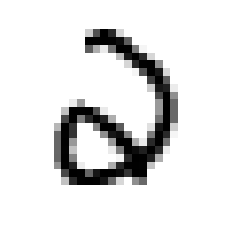

In [98]:
i = np.random.choice(len(X))
i = 36006 # specify one image
some_digit = X[i]
plot_digit(some_digit)
print('training point:', i, ' is digit', int(y[i]))

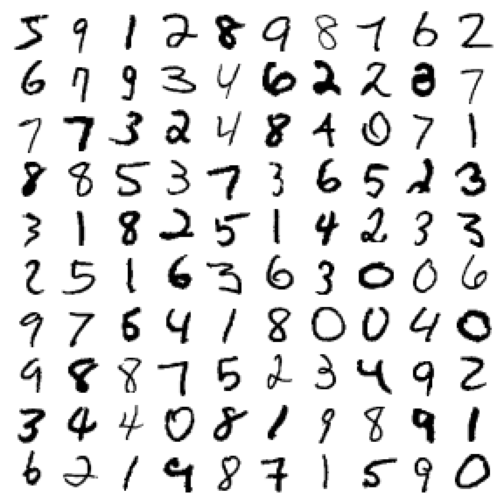

In [39]:
plt.figure(figsize=(9,9))
# row-wise merging
# start:end:stepsize
example_images = np.r_[X[:12000:600], X[13000:30600:600], X[30600:60000:590]]
plot_digits(example_images, images_per_row=10)
plt.show()

In [40]:
y[:-1]

array([5, 0, 4, ..., 3, 4, 5])

In [41]:
y[1:]

array([0, 4, 1, ..., 4, 5, 6])

Text(0.5, 1.0, 'full dataset')

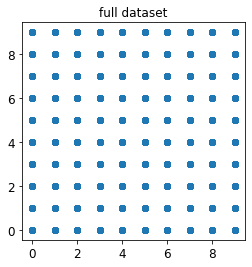

In [42]:
# Note that the test and training data are already prepared in this dataset
# this however is be depreciated in the Sklearn 0.20
fig, ax = plt.subplots(1,1, figsize=[4,4])
ax.scatter(y[:-1], y[1:], marker='o', linewidth=0)
ax.set_title('full dataset')

In [43]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]
shuffle_index = np.random.permutation(60000)
X_train, y_train = X_train[shuffle_index], y_train[shuffle_index]

# Build Pipeline

In [81]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score


# Dictionary containing grid Hyperparameters
grid_params = {
    'knn__p': [1,2],
    'knn__n_neighbors': [2,3,4,5]
}

# Dictionary containing scoring metrics for Cross-Validation
# scoring_params = {#'accuracy' : make_scorer(accuracy_score), 
#                   #'precision' : make_scorer(precision_score),
#                   #'recall' : make_scorer(recall_score), 
#                   'f1_score' : make_scorer(f1_score)
#                  }

# Build Pipeline
gs_mnist = GridSearchCV(
    Pipeline([
            ('std_scaler', StandardScaler()),
            ('knn', KNeighborsClassifier(weights='uniform',    # every vote has the same value
                                         algorithm = 'auto',
                                         metric='minkowski',   # minkowski distance
                                         n_jobs=2             # use all processors
                                        )
            )
    ]),
    grid_params,
    scoring = 'f1_weighted',
    #refit = 'f1_score',
    verbose = 4,          # set to 1 is equivalent to no bs
    cv = 3,         # (Stratified) 3-Fold Cross-Validation
    n_jobs=2             # use all processors
)


# Fit the train_set
gs_results = gs_mnist.fit(X_train, y_train)

Fitting 3 folds for each of 8 candidates, totalling 24 fits


In [82]:
gs_results.best_score_

0.9564916044863588

In [83]:
gs_results.best_estimator_

Pipeline(steps=[('std_scaler', StandardScaler()),
                ('knn', KNeighborsClassifier(n_jobs=2, n_neighbors=3, p=1))])

In [84]:
gs_results.best_params_

{'knn__n_neighbors': 3, 'knn__p': 1}

[CV 2/3] END ......knn__n_neighbors=2, knn__p=1;, score=0.944 total time= 7.1min
[CV 1/3] END ......knn__n_neighbors=2, knn__p=2;, score=0.929 total time=  38.8s
[CV 2/3] END ......knn__n_neighbors=2, knn__p=2;, score=0.929 total time=  43.1s
[CV 3/3] END ......knn__n_neighbors=2, knn__p=2;, score=0.930 total time=  41.5s
[CV 1/3] END ......knn__n_neighbors=3, knn__p=1;, score=0.957 total time= 7.3min
[CV 3/3] END ......knn__n_neighbors=3, knn__p=1;, score=0.956 total time= 7.4min
[CV 1/3] END ......knn__n_neighbors=4, knn__p=1;, score=0.955 total time= 7.4min
[CV 3/3] END ......knn__n_neighbors=4, knn__p=1;, score=0.954 total time= 7.3min
[CV 2/3] END ......knn__n_neighbors=5, knn__p=1;, score=0.957 total time= 7.3min
[CV 1/3] END ......knn__n_neighbors=5, knn__p=2;, score=0.942 total time=  49.2s
[CV 2/3] END ......knn__n_neighbors=5, knn__p=2;, score=0.941 total time=  47.7s
[CV 3/3] END ......knn__n_neighbors=5, knn__p=2;, score=0.942 total time=  48.1s
[CV 1/3] END ......knn__n_ne

**Therefore, given by the $\texttt{GridSearchCV}$, the optimal $p$ is $p=1$, and the optimal $n\_neighbors$ is $n\_neighbors=3$.**

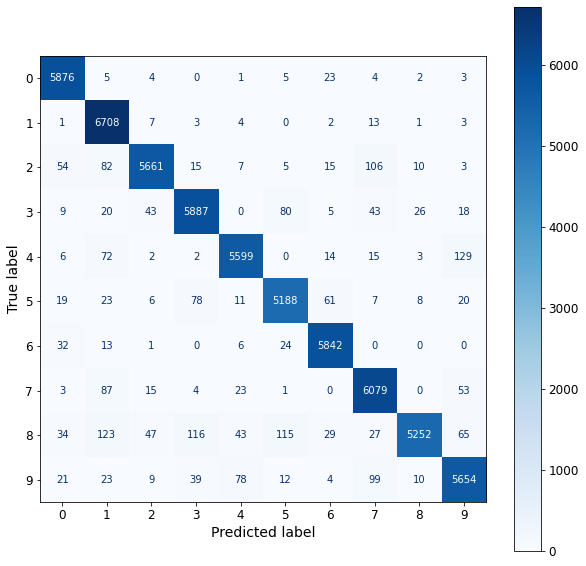

In [85]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

optimal_knn = KNeighborsClassifier(n_neighbors=3,
                                   weights='uniform',    # every vote has the same value
                                   algorithm = 'auto',
                                   p=1,
                                   metric='minkowski',   # minkowski distance
                                   n_jobs=2             # use all processors
                                )
# our predictions using cross validation on training set
knn_preds = cross_val_predict(optimal_knn, X_train, y_train, cv=3)

# Build the confusion matrix
cf_matrix = confusion_matrix(y_train, knn_preds)

# Display it
cm_fig, cm_ax = plt.subplots(figsize=(10, 10))
cf_matrix_disp = ConfusionMatrixDisplay(cf_matrix)
cf_matrix_disp.plot(ax=cm_ax, cmap=plt.cm.Blues)
plt.show()

In [86]:
for i in range(10):
    accuracy = 1-(np.sum(cf_matrix[i], axis=0)-cf_matrix[i][i])/np.sum(cf_matrix[i], axis=0)
    print(f'The accuracy for digit {i} is', accuracy)

The accuracy for digit 0 is 0.9920648320108053
The accuracy for digit 1 is 0.9949569860575497
The accuracy for digit 2 is 0.9501510574018127
The accuracy for digit 3 is 0.9602022508563041
The accuracy for digit 4 is 0.9584046559397467
The accuracy for digit 5 is 0.9570190001844678
The accuracy for digit 6 is 0.9871578235890504
The accuracy for digit 7 is 0.9703112529928173
The accuracy for digit 8 is 0.8976243377200479
The accuracy for digit 9 is 0.9504118339216675


(b) From the accuracies above, we know that **digit 8** confuses the model the most.

# Plot the MNIST Data in t-SNE format

CPU times: user 2 µs, sys: 6 µs, total: 8 µs
Wall time: 24.8 µs
CPU times: user 2 µs, sys: 1e+03 ns, total: 3 µs
Wall time: 5.01 µs


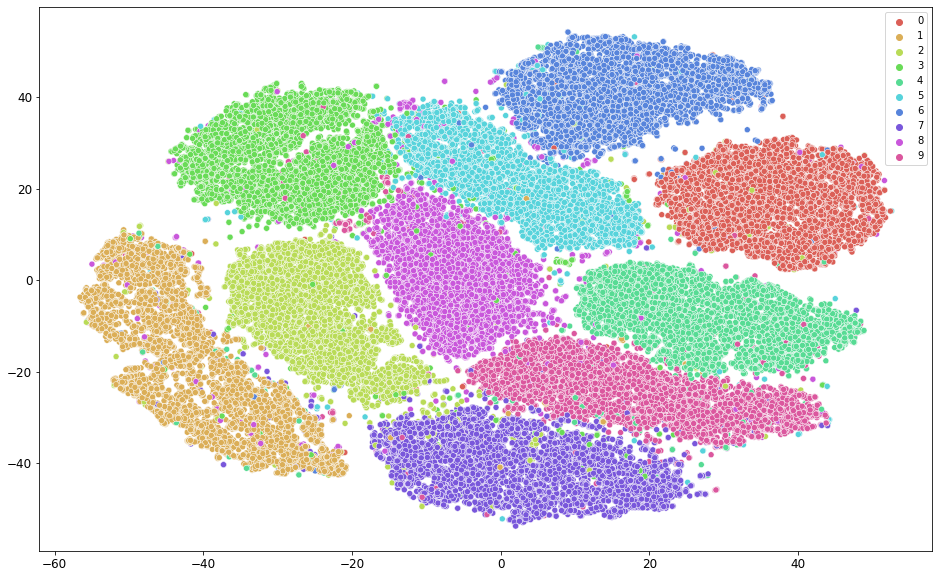

In [87]:
from sklearn.manifold import TSNE
import seaborn as sns
%time
tsne = TSNE(n_components = 2, random_state=0)
tsne_res = tsne.fit_transform(X_train)
plt.figure(figsize=(16,10))

sns.scatterplot(x = tsne_res[:,0], y = tsne_res[:,1], hue = y_train, palette = sns.hls_palette(10), legend = 'full');
%time

(c) In the previous question, we see that **digit 8** confuses our model the most. This is explicitly presented in this t-SNE plot for the MNIST data since the purple dots which represents the true digit 8 data points are everywhere in the graph. Such data structure introduced a lot of noise when we were fitting our model, and that's why **digit 8** confuses our model the most.

(d) The optimal Minkowski parameter $p$ from the first part is closer to $p=1$. This is because all data points, as we can see from the t-SNE plot, are closely aggregated and have very high dimensionality. In a space with such high dimensionality, the numerical values of the Euclidean distances ($p=2$), even for two points in different categories, become very similar because you have to take the square root. So, we want to use metrics like $p=1$ (Manhattan Distance) to make the differences between distances more explicit so as to differentiate points from different classes.

# PCA of Constant Maturity Treasury Rates

## (a)

In [202]:
import pandas as pd
from datetime import datetime

The question restricted the dates from 1/1/2001-12/31/2022. However, there are no data for 1/1/2001, 12/31/2022 and some other dates in between, so we start with 1/2/2001.

### Special treatment for 1MO data

The 1MO data from 1/2/2001 to 7/30/2001 are misssing (total 150), so we use the 3MO data to substitute the original 1MO data since they are pretty much similar.

In [278]:
# Read 1MO and 3MO data
df_1MO = pd.read_csv(f'Fed/DGS1MO.csv')
df_3MO = pd.read_csv(f'Fed/DGS3MO.csv')

# Fetch the rates data
rates_1MO = df_1MO['DGS1MO']
rates_3MO = df_3MO['DGS3MO']

# Pad the first 150 data points in DGS1MO with the corresponding values in DGS3MO
padded_rates_1MO = list(rates_3MO[:150])+list(rates_1MO)

# Make a new DataFrame to store the padded data
new_df_1MO = pd.DataFrame([])
new_df_1MO['DATE'] = df_3MO['DATE']
new_df_1MO['DGS1MO'] = [float(i) if i is not '.' else np.nan for i in padded_rates_1MO ]
#print(new_df_1MO.to_string())

In [282]:
# Start with the padded DGS1Mo Data
aggregated_rates = new_df_1MO

# Add all other dataset in the aggregated DataFrame
for csv in ['3MO', '6MO', '1', '2', '3', '5', '10', '20', '30']:
    df = pd.read_csv(f'Fed/DGS{csv}.csv')
    data = [float(i) if i is not '.' else np.nan for i in df[df.columns[1]] ]
    aggregated_rates[df.columns[1]] = data

# convert the date to datetime object
aggregated_rates['DATE'] = pd.to_datetime(df['DATE'])

# Set the index to dates
aggregated_rates = aggregated_rates.set_index('DATE')

# # Check if our data looks great
print(aggregated_rates.info())
aggregated_rates.head()
# print(aggregated_rates.to_string())

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5739 entries, 2001-01-02 to 2022-12-30
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DGS1MO  5502 non-null   float64
 1   DGS3MO  5502 non-null   float64
 2   DGS6MO  5502 non-null   float64
 3   DGS1    5502 non-null   float64
 4   DGS2    5502 non-null   float64
 5   DGS3    5502 non-null   float64
 6   DGS5    5502 non-null   float64
 7   DGS10   5502 non-null   float64
 8   DGS20   5502 non-null   float64
 9   DGS30   5502 non-null   float64
dtypes: float64(10)
memory usage: 493.2 KB
None


,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS10,DGS20,DGS30
DATE,,,,,,,,,,
2001-01-02,5.87,5.87,5.58,5.11,4.87,4.82,4.76,4.92,5.46,5.35
2001-01-03,5.69,5.69,5.44,5.04,4.92,4.92,4.94,5.14,5.62,5.49
2001-01-04,5.37,5.37,5.20,4.82,4.77,4.78,4.82,5.03,5.56,5.44
2001-01-05,5.12,5.12,4.98,4.60,4.56,4.57,4.66,4.93,5.50,5.41
2001-01-08,5.19,5.19,5.03,4.61,4.54,4.55,4.65,4.94,5.52,5.42


### Resample our data to weekly frequency

In [290]:
# Drop all the NaN values in the DataFrame
aggregated_rates.dropna()

# Resample our data to weekly frequency using the mean of the week as the value
# for each entry
resampled_aggregated_rates = aggregated_rates.resample('W').mean()

# Check the basic info of our data
resampled_aggregated_rates.info()

# Check if our data is looking great
resampled_aggregated_rates.head()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 1148 entries, 2001-01-07 to 2023-01-01
Freq: W-SUN
Data columns (total 10 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   DGS1MO  1148 non-null   float64
 1   DGS3MO  1148 non-null   float64
 2   DGS6MO  1148 non-null   float64
 3   DGS1    1148 non-null   float64
 4   DGS2    1148 non-null   float64
 5   DGS3    1148 non-null   float64
 6   DGS5    1148 non-null   float64
 7   DGS10   1148 non-null   float64
 8   DGS20   1148 non-null   float64
 9   DGS30   1148 non-null   float64
dtypes: float64(10)
memory usage: 98.7 KB


,DGS1MO,DGS3MO,DGS6MO,DGS1,DGS2,DGS3,DGS5,DGS10,DGS20,DGS30
DATE,,,,,,,,,,
2001-01-07,5.5125,5.5125,5.300,4.8925,4.780,4.7725,4.7950,5.005,5.5350,5.4225
2001-01-14,5.2720,5.2720,5.142,4.7880,4.722,4.7340,4.8060,5.082,5.6120,5.5040
2001-01-21,5.3150,5.3150,5.190,4.8525,4.800,4.8050,4.8525,5.185,5.6475,5.5375
2001-01-28,5.2400,5.2400,5.116,4.8260,4.788,4.8120,4.9360,5.292,5.7460,5.6360
2001-02-04,5.0360,5.0360,4.908,4.6580,4.658,4.7040,4.8740,5.204,5.6520,5.5580


### Save our resampled data to $\texttt{price.csv}$

In [291]:
resampled_aggregated_rates.to_csv('price.csv')

## (b)

### Extend TimeSeriesSplit class to RolledTimeSeriesSplit class 

Create RolledTimeSeriesSplit class as an extension of the original TimeSeriesSplit class

In [497]:
from sklearn.base import BaseEstimator, TransformerMixin

In [607]:
from sklearn.model_selection import TimeSeriesSplit
class RolledTimeSeriesSplit(TimeSeriesSplit, BaseEstimator, TransformerMixin):
    def __init__(self, n_splits=5, train_test_ratio=5):
        self.n_splits = n_splits
        self.train_test_ratio = train_test_ratio
        
    def split(self, X, y=None, groups=None):
        original_spliter = TimeSeriesSplit(n_splits=self.n_splits)
        for i, (train_index, test_index) in enumerate(original_spliter.split(X)):
            bounded_length = int(np.floor(self.train_test_ratio * len(test_index)))
            #print("dasfa",bounded_length)
            if self.train_test_ratio is not None:
                if len(train_index) > bounded_length:
                    train_index = train_index[-bounded_length:]
                yield(train_index, test_index)
                
    def fit(self, X, y=None):
        return self
    
    def transform(self, X, y=None):
        listt = []
        for i, (train_index, test_index) in enumerate(self.split(X)):
            listt.append(X.iloc[train_index])
        return listt
            

In [ ]:
tscv = TimeSeriesSplit(n_splits=4)
for i, (train_index, test_index) in enumerate(tscv.split(resampled_aggregated_rates)):
    print(f"Fold {i}:")
    print(f"  Train: index={train_index}, length={len(train_index)}")
    print(f"  Test:  index={test_index}, length={len(test_index)}")

In [608]:
rolled = RolledTimeSeriesSplit(n_splits=22, train_test_ratio=5)
for i, (rolled_train_index, rolled_test_index) in enumerate(rolled.split(resampled_aggregated_rates)):
    print(f"Fold {i}:")
    print(f"  Train: index={rolled_train_index}, length={len(rolled_train_index)}")
    print(f"  Test:  index={rolled_test_index}, length={len(rolled_test_index)}")

Fold 0:
  Train: index=[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23
 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47
 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69], length=70
  Test:  index=[ 70  71  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87
  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105
 106 107 108 109 110 111 112 113 114 115 116 117 118], length=49
Fold 1:
  Train: index=[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118], length=119
  Test:

### Explain

**We can see the magnitude of the train indices stopped expanding when it hit $len(test\_index)*ratio = 49*5$**

### Extend PCA class to MyPCA class 

In [677]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

class MyPCA(PCA, BaseEstimator):
    def __init__(self, n_components=1,plot=True, copy=True, whiten=False, svd_solver='auto', tol=0.0, iterated_power='auto', n_oversamples=10, power_iteration_normalizer='auto', random_state=None): #, copy=True, svd_solver='auto'
        self.n_components=n_components
        self.plot=plot
        self.copy = copy
        self.whiten = whiten
        self.svd_solver = svd_solver
        self.tol = tol
        self.iterated_power = iterated_power
        self.n_oversamples = n_oversamples
        self.power_iteration_normalizer = power_iteration_normalizer
        self.random_state = random_state
        
    def fit(self, X, y=None, groups=None):
        if not isinstance(X, list):
            pca = PCA(n_components=self.n_components)
            fitted_X = pca.fit(X)
            if self.plot == True:
                self.plot_components(X, fitted_X)
        else:
            pca = PCA(n_components=self.n_components)
            for i in range(len(X)):
                fitted_X = pca.fit(X[i])
                if self.plot == True:
                    self.plot_components(X[i], fitted_X)
        return self
    
    def fit_transform(self, X, y=None):
        """
        make MyPCA compatible with Pipeline and GridSearchCV
        """
        # if the input X is not a list of DataFrame 
        if not isinstance(X, list):
            
            # use the original PCA to fit our data
            pca = PCA(n_components=self.n_components)
            fitted_X = pca.fit(X)
            
            # plot pca_components
            if self.plot == True:
                self.plot_components(X, fitted_X)
            return fitted_X.components_, fitted_X.explained_variance_ratio_.sum()
        else:
            # make two lists to store pca_components and total_explained_variance
            # for each DataFrame in X
            components_for_all_splits = []
            explained_variance_for_all_splits = []
            
            # use the original PCA to fit each data (DataFrame)
            # We have to do this since our input X in this case is a list of DataFrames
            pca = PCA(n_components=self.n_components)
            for i in range(len(X)):
                fitted_X = pca.fit(X[i])
                
                # update the two lists
                components_for_all_splits.append(fitted_X.components_)
                explained_variance_for_all_splits.append(fitted_X.explained_variance_ratio_.sum())
                
                # plot pca_components
                if self.plot == True:
                    self.plot_components(X[i], fitted_X)
            return components_for_all_splits, explained_variance_for_all_splits
        
    def plot_components(self, X, fitted_X):
        plt.figure(figsize=(12,9))
        for i in range(len(fitted_X.components_)):
            plt.plot(X.columns, fitted_X.components_[i])
        start_date = X.index[0]
        end_date = X.index[-1]
        plt.xlabel('Tenor') 
        plt.ylabel('Level') 
        plt.title(f'The explained variance ratio is {fitted_X.explained_variance_ratio_[0]}, {start_date} to {end_date}')

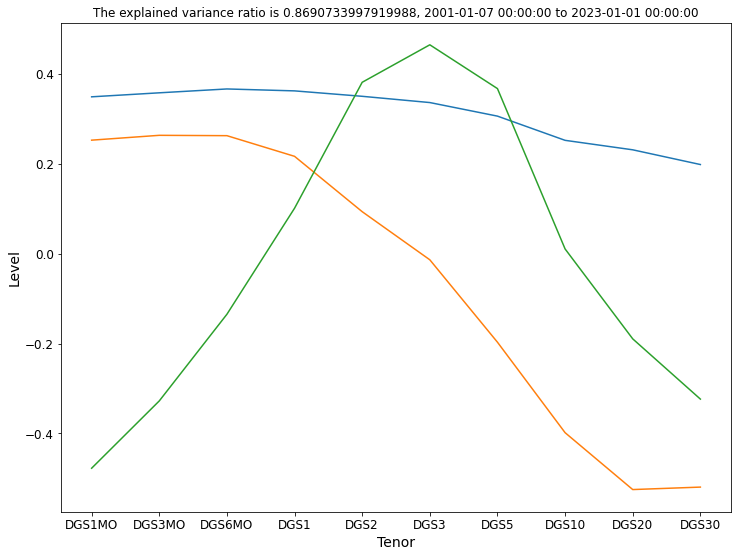

In [678]:
mypca = MyPCA(n_components=3, plot=True)
gg = mypca.fit(resampled_aggregated_rates)

**MyPCA looks good.**

## (d)

### Let's make a Pipeline

In [679]:
from sklearn.pipeline import Pipeline

my_pipeline = Pipeline([
        # RolledTimeSeriesSplit for Cross-Validation
        ('RolledTimeSeriesSplit', RolledTimeSeriesSplit(n_splits=22, train_test_ratio=5)),  
        # MyPCA
        ('MyPCA', MyPCA(n_components=1, plot=True))      
    ])

### Run our Pipeline

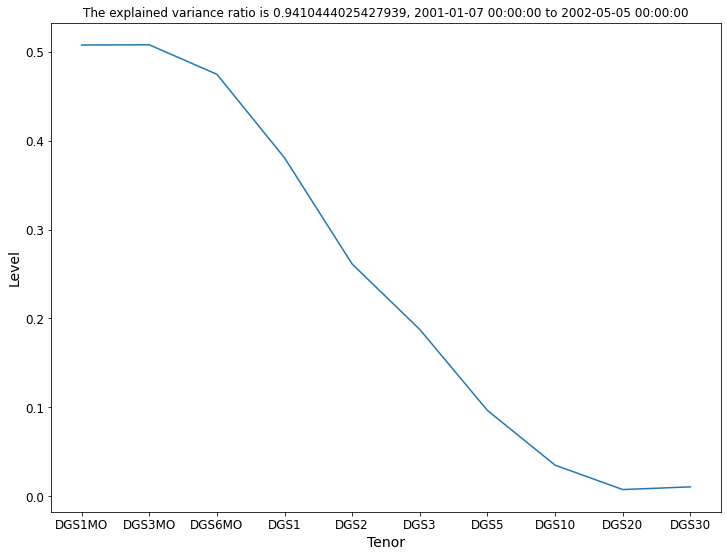

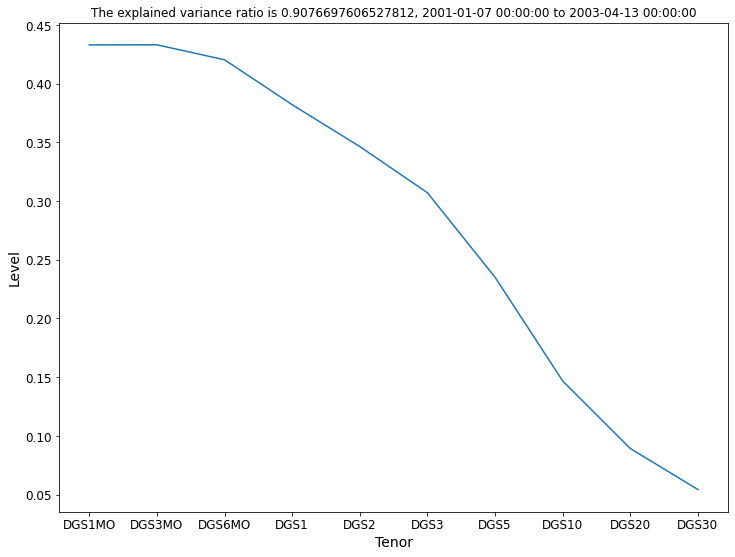

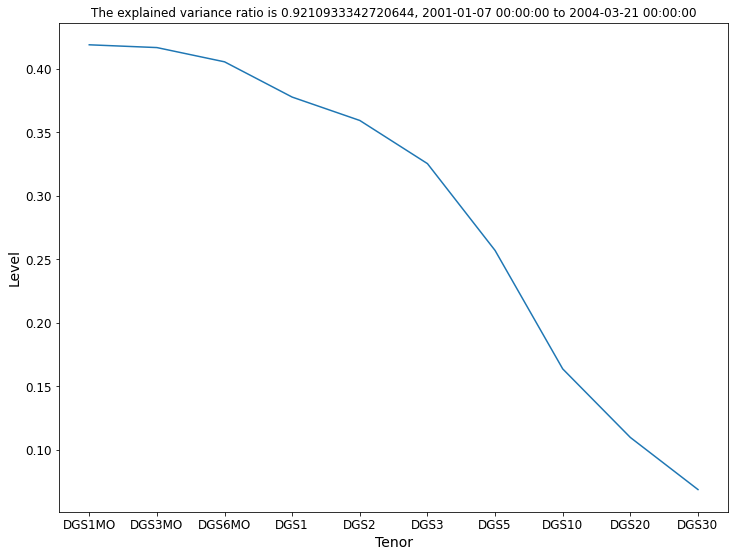

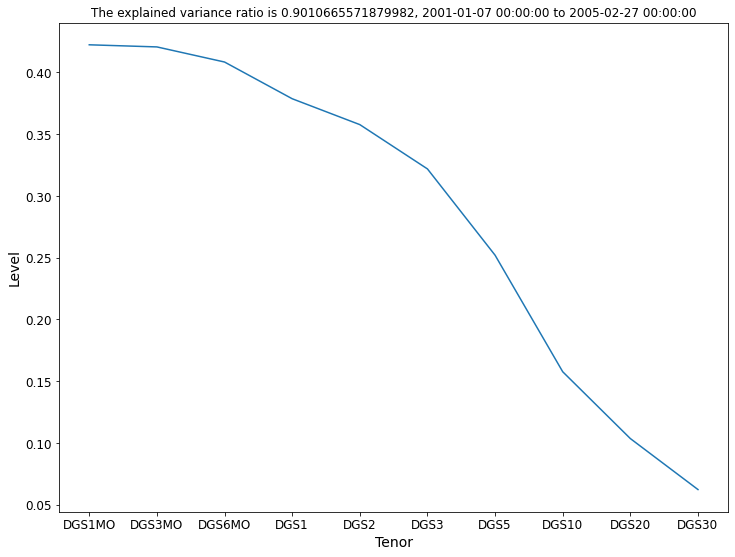

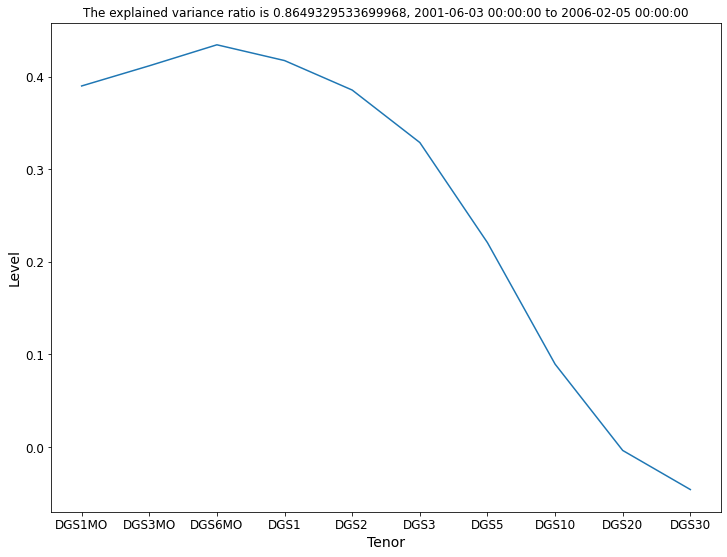

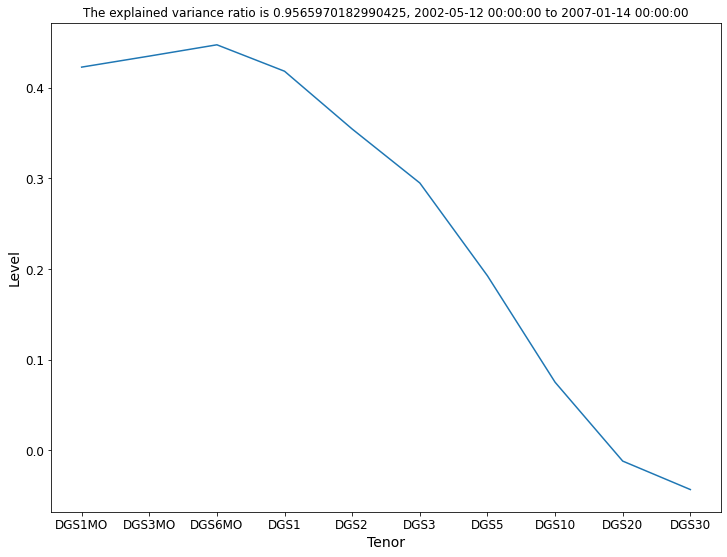

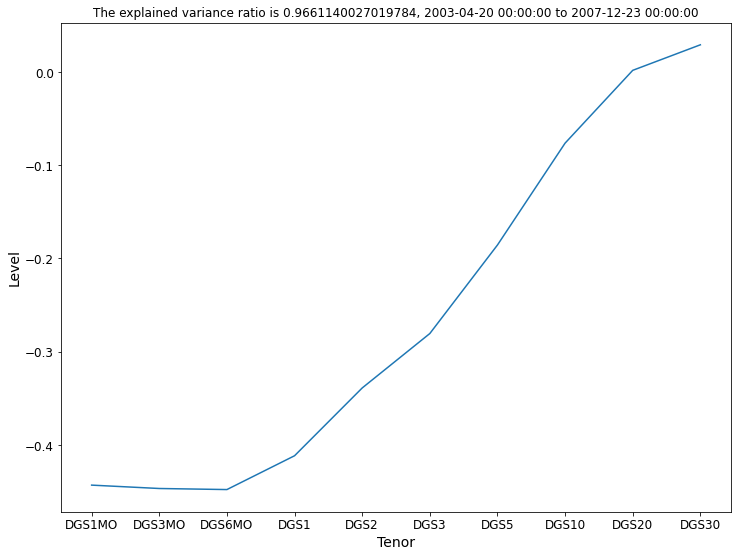

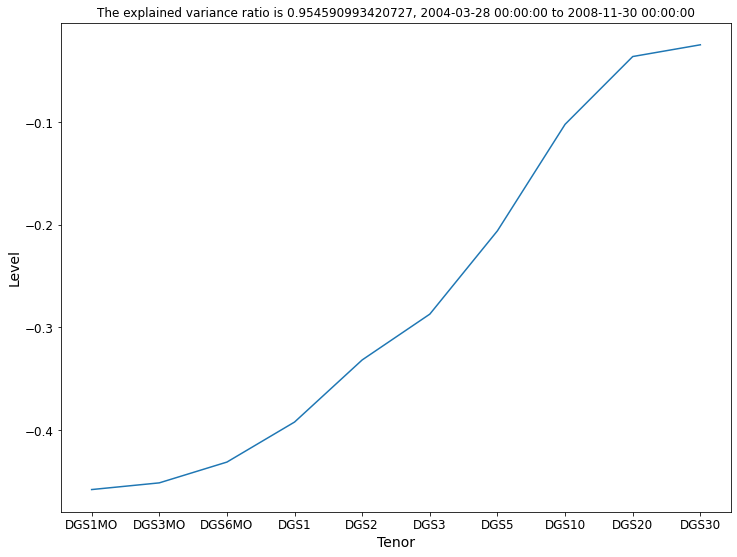

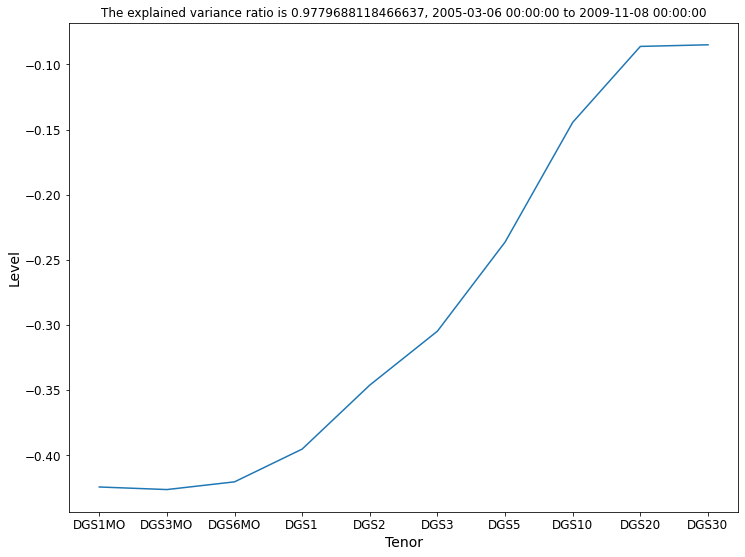

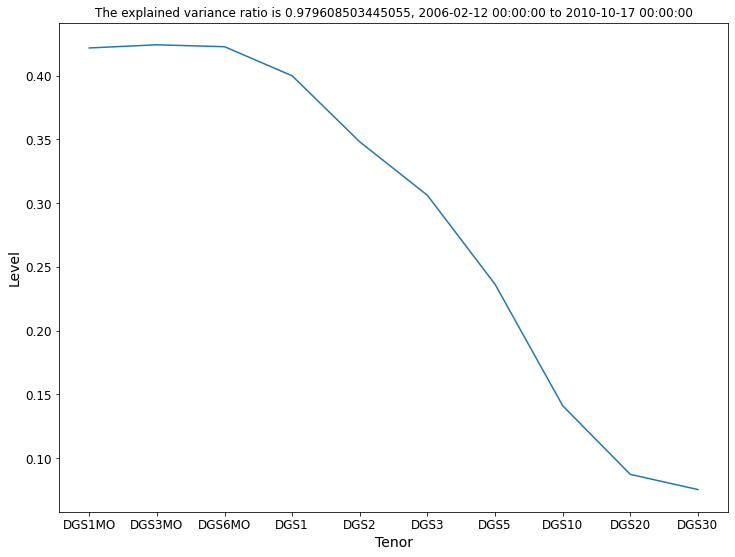

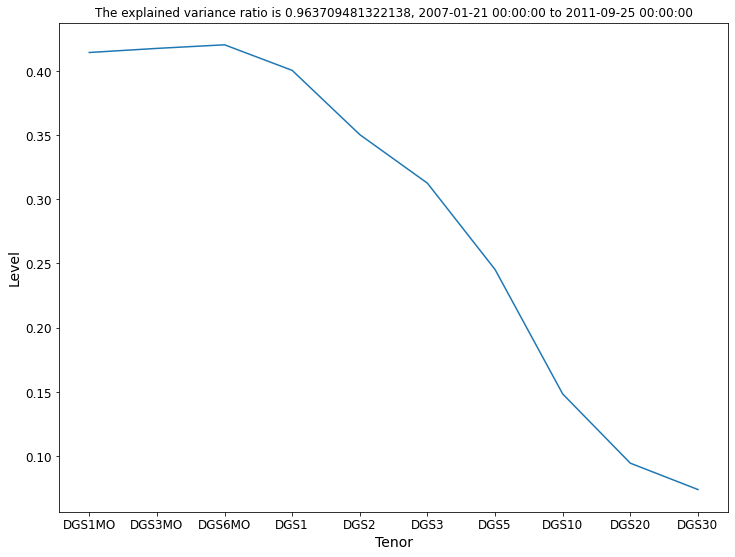

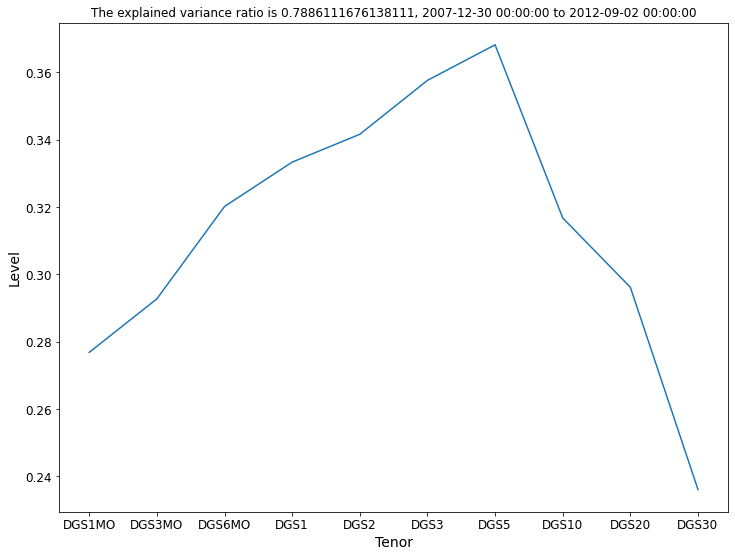

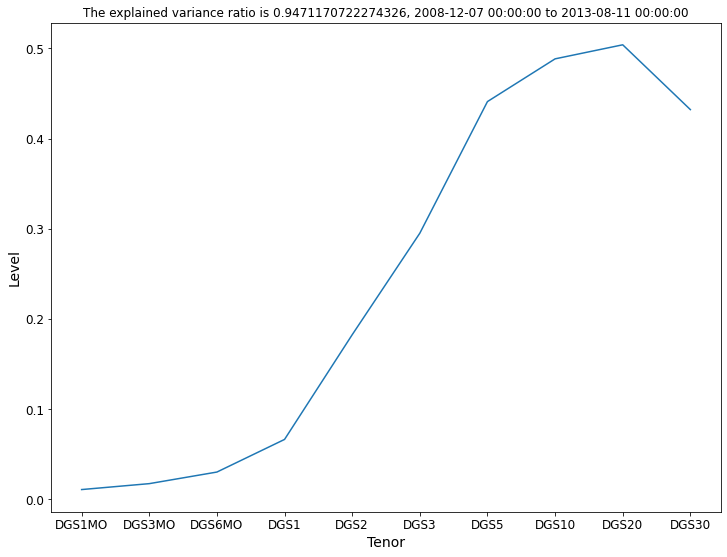

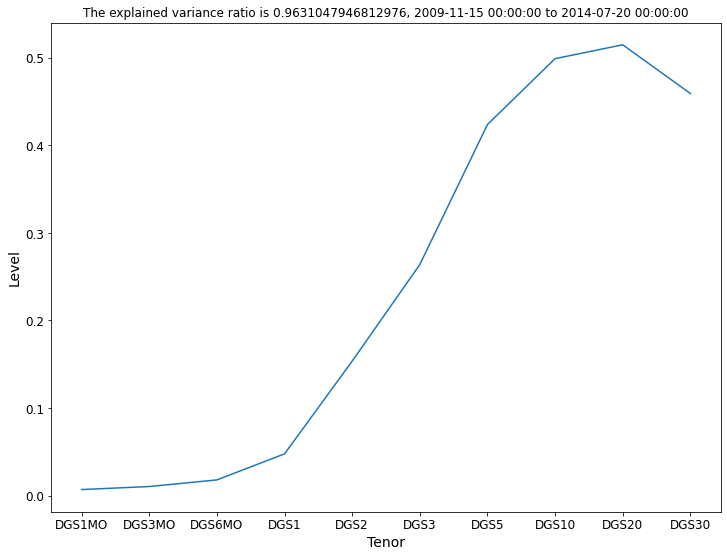

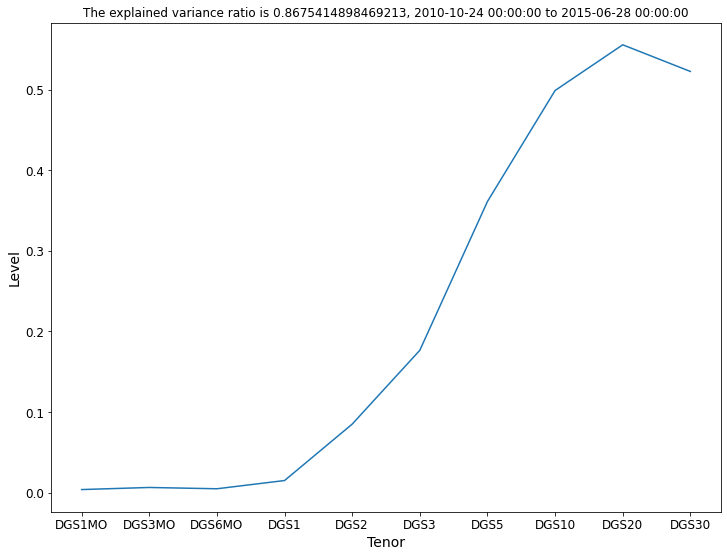

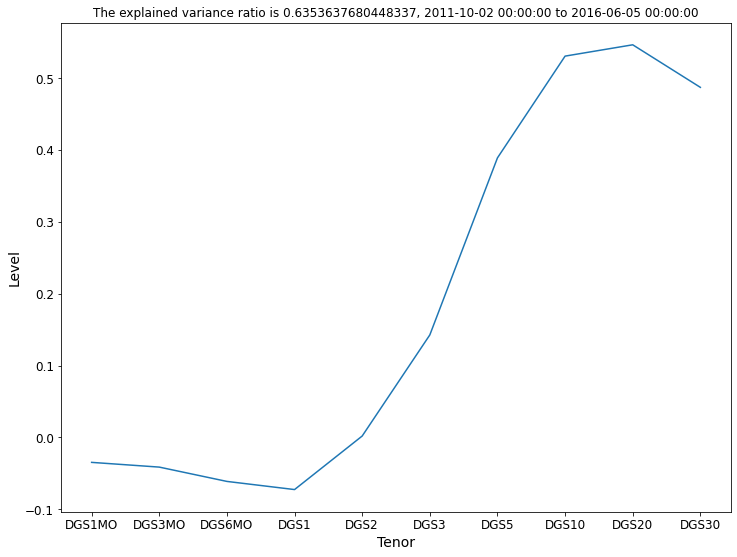

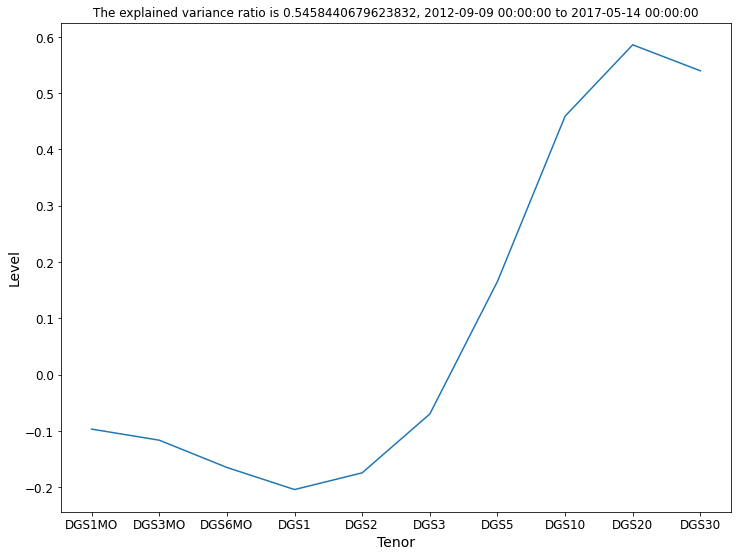

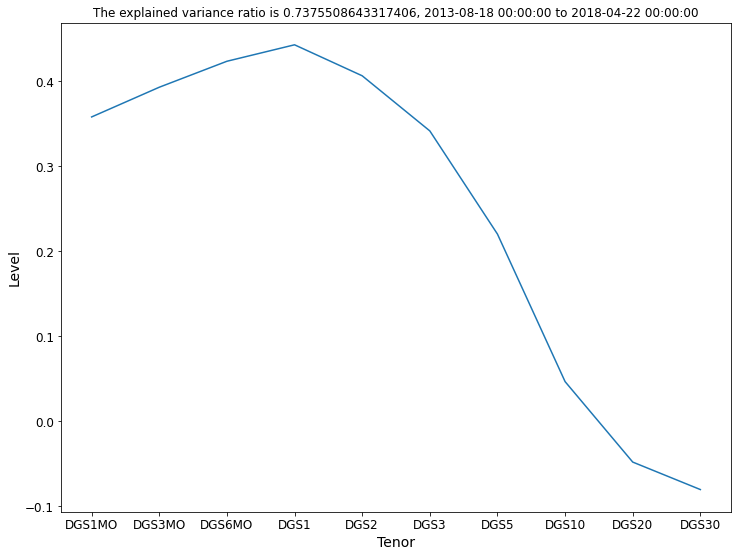

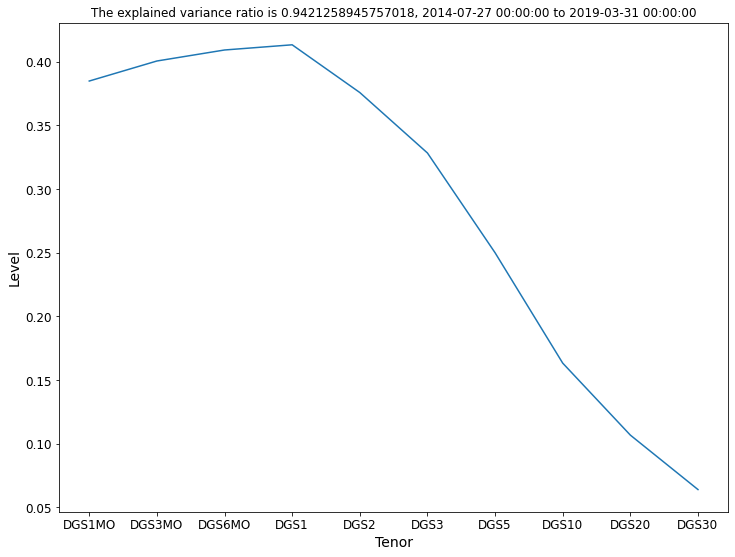

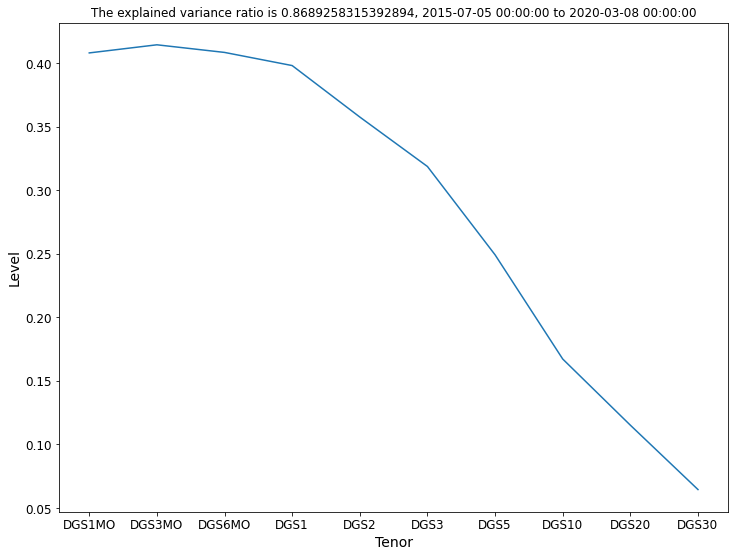

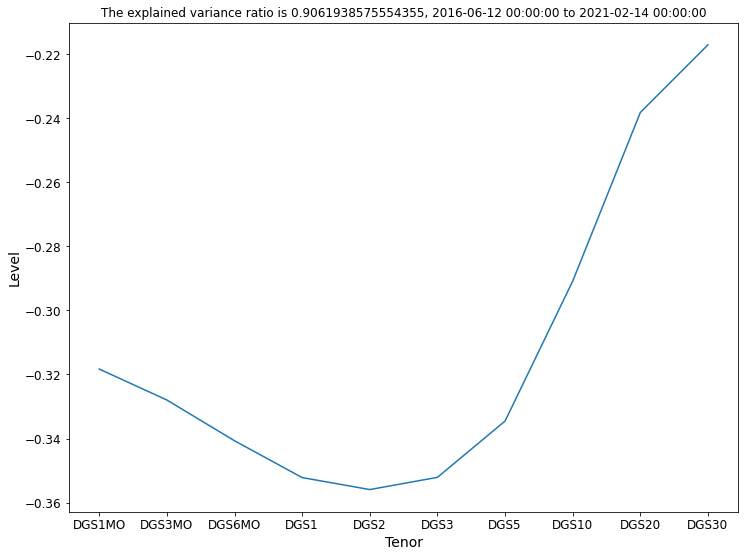

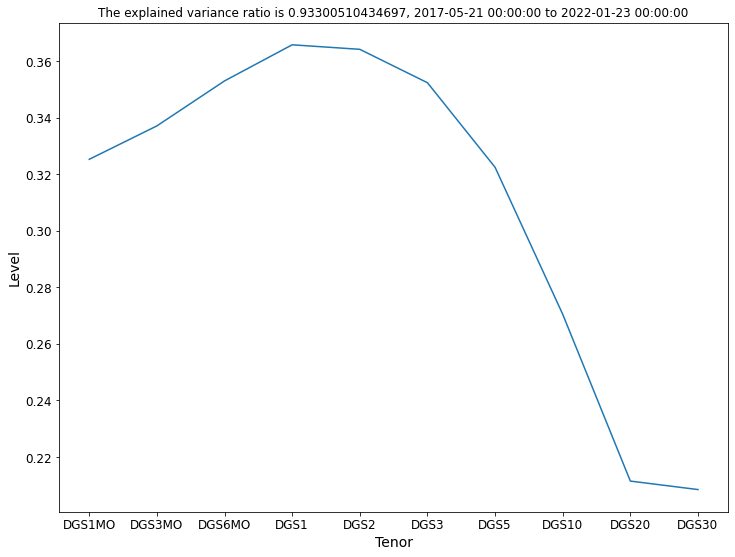

In [680]:
transformed_resampled_aggregated_rates = my_pipeline.fit_transform(resampled_aggregated_rates)

In [ ]:
print(transformed_resampled_aggregated_rates)

**Indeed, they are periods where the explained variance ratio changes significantly.**

## (f)

### GridSearch

In [682]:
# Grid Search Hyperparameters
for n_splits in [22,44]:
    for train_test_ratio in [2,3,4,5]:
        grid_search_pipeline = Pipeline([
            # RolledTimeSeriesSplit for Cross-Validation
            ('RolledTimeSeriesSplit', RolledTimeSeriesSplit(n_splits=n_splits, train_test_ratio=train_test_ratio)),  
            # MyPCA
            ('MyPCA', MyPCA(n_components=3, plot=False))      
        ])
        transformed_resampled_aggregated_rates = grid_search_pipeline.fit_transform(resampled_aggregated_rates)
        mean_total_explained_variance = np.mean(transformed_resampled_aggregated_rates[1])
        print(f'The mean of total explained variance when n_splits={n_splits} and train_test_ratio={train_test_ratio} is ', mean_total_explained_variance)

The mean of total explained variance when n_splits=22 and train_test_ratio=2 is  0.9958182268657434
The mean of total explained variance when n_splits=22 and train_test_ratio=3 is  0.9965480328380315
The mean of total explained variance when n_splits=22 and train_test_ratio=4 is  0.9970419682491773
The mean of total explained variance when n_splits=22 and train_test_ratio=5 is  0.997322712588074
The mean of total explained variance when n_splits=44 and train_test_ratio=2 is  0.99465339878429
The mean of total explained variance when n_splits=44 and train_test_ratio=3 is  0.9951513612166244
The mean of total explained variance when n_splits=44 and train_test_ratio=4 is  0.9958279657532199
The mean of total explained variance when n_splits=44 and train_test_ratio=5 is  0.9962186204676473


**We can clearly see that the optimal hyperparameters are n_splits=22 and train_test_ratio=5**

### plots for the time evolution of the PCA components for the optimal model

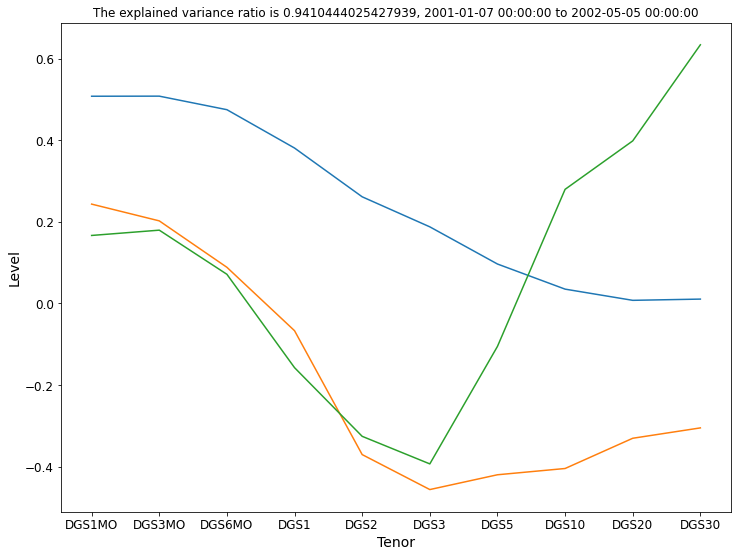

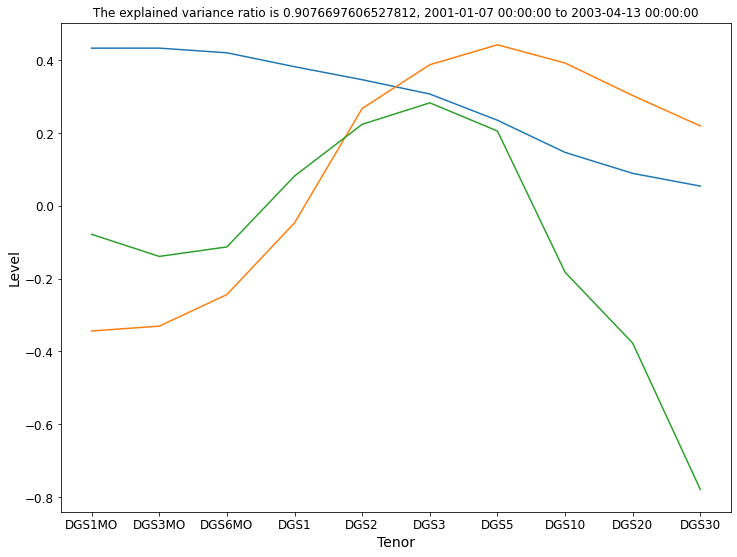

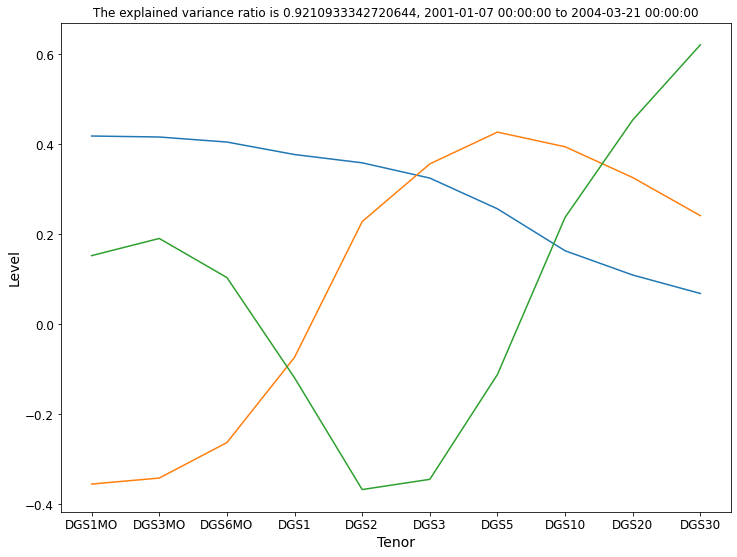

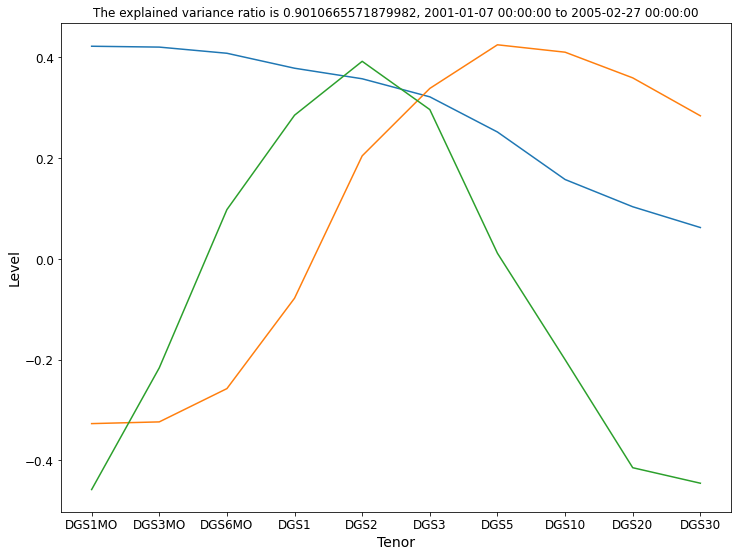

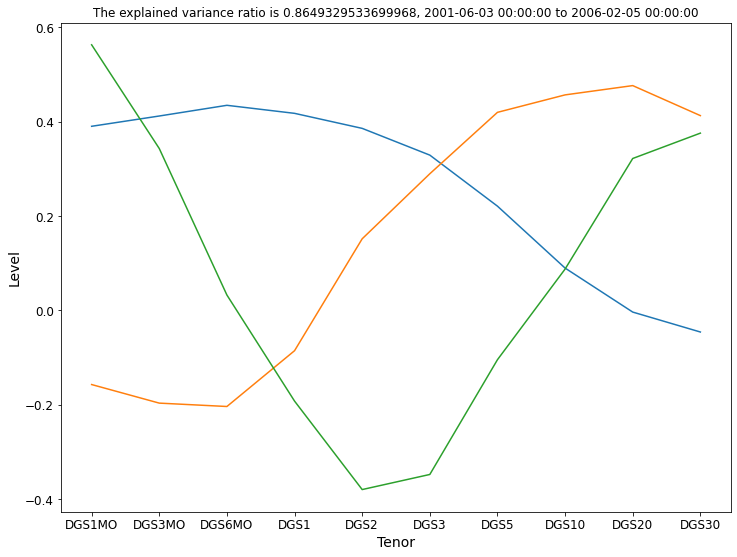

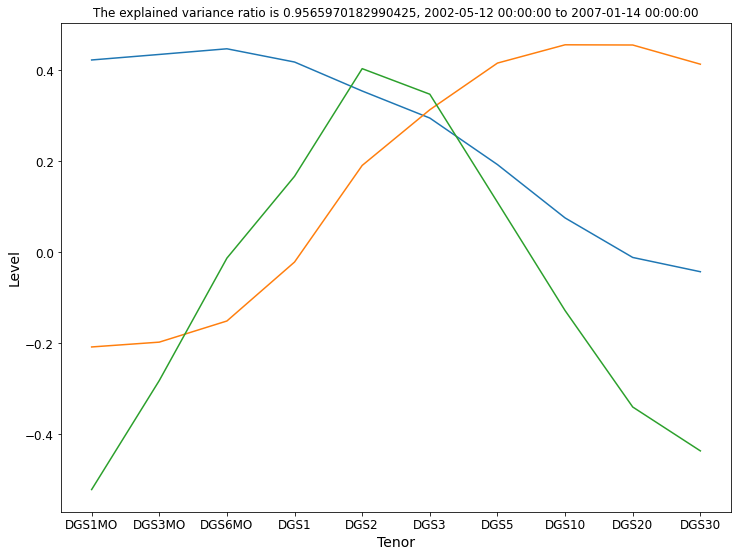

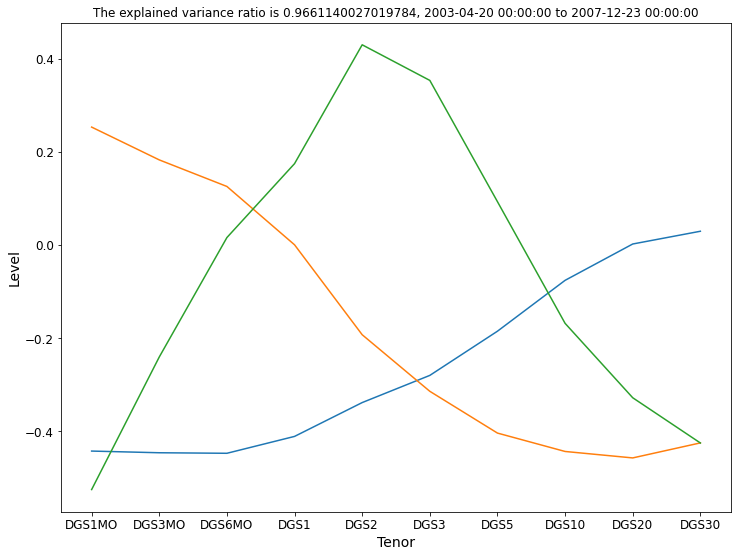

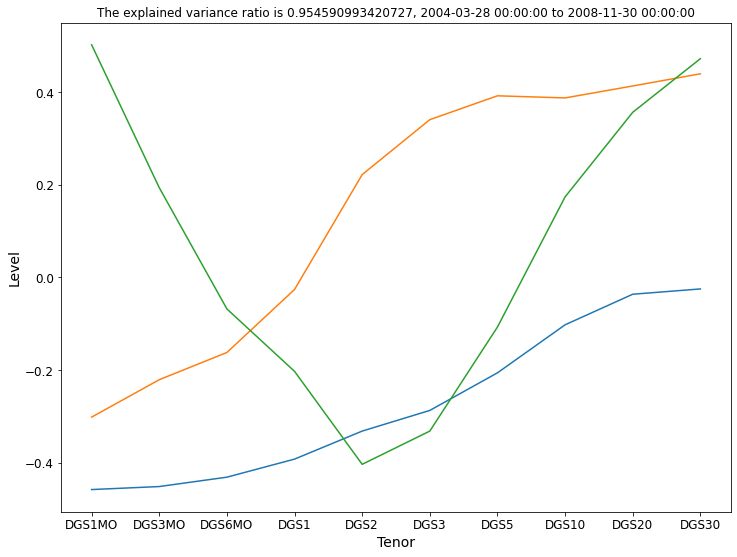

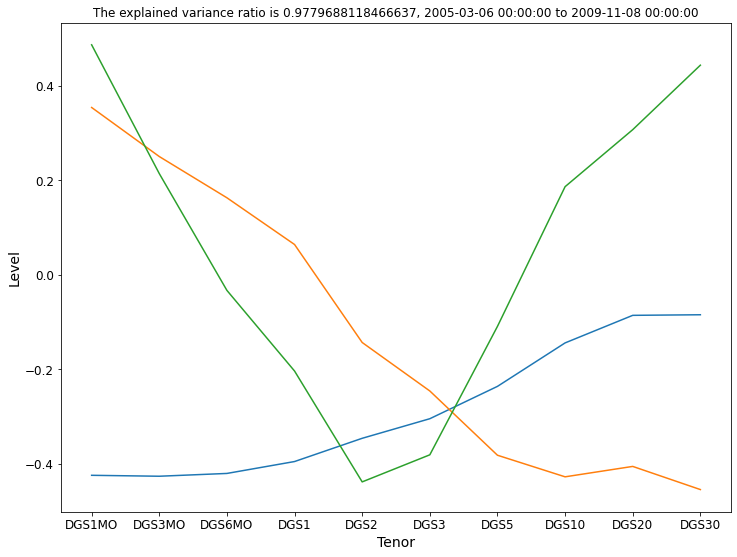

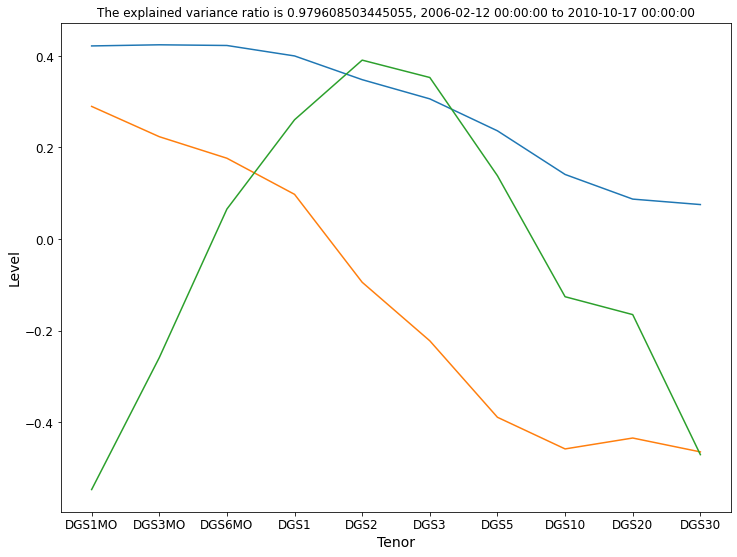

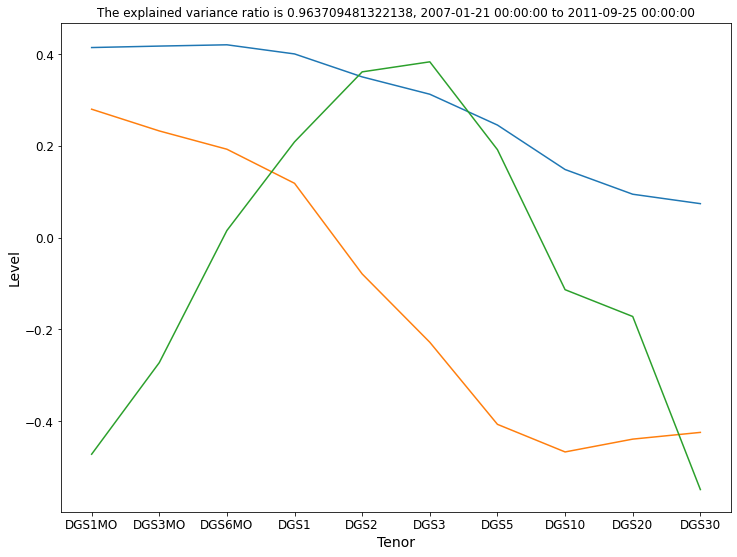

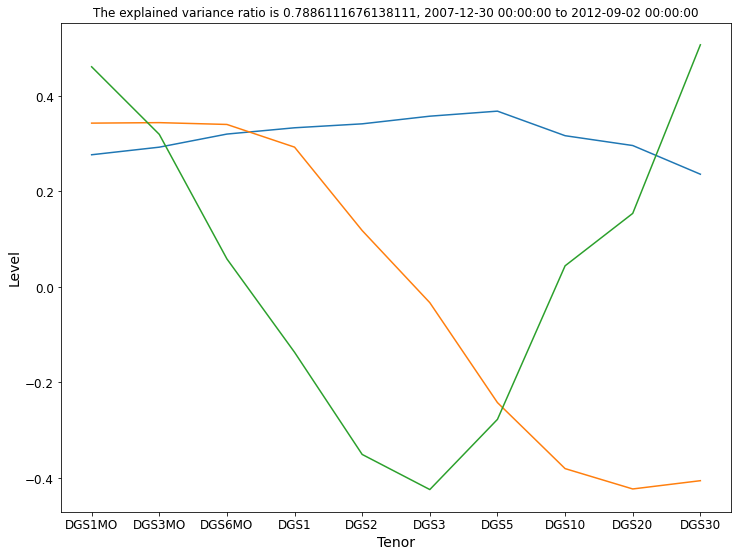

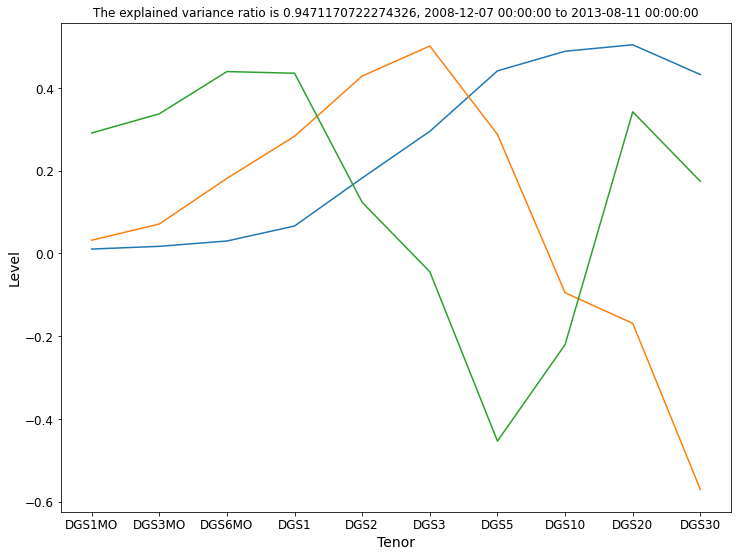

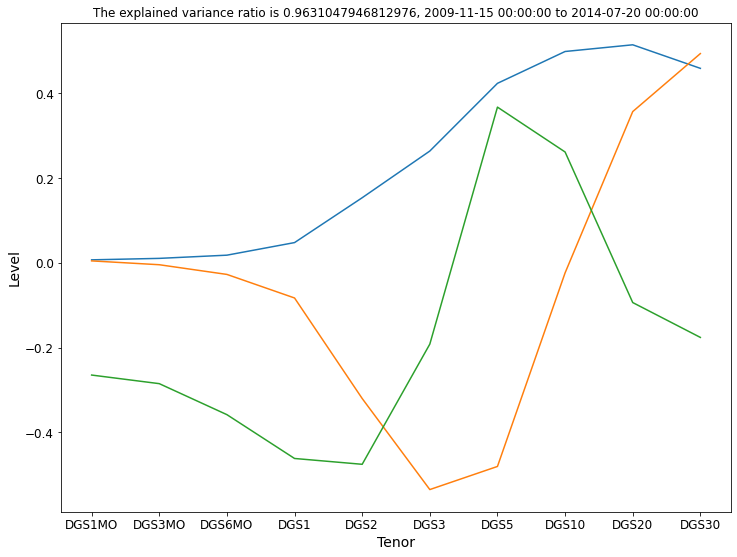

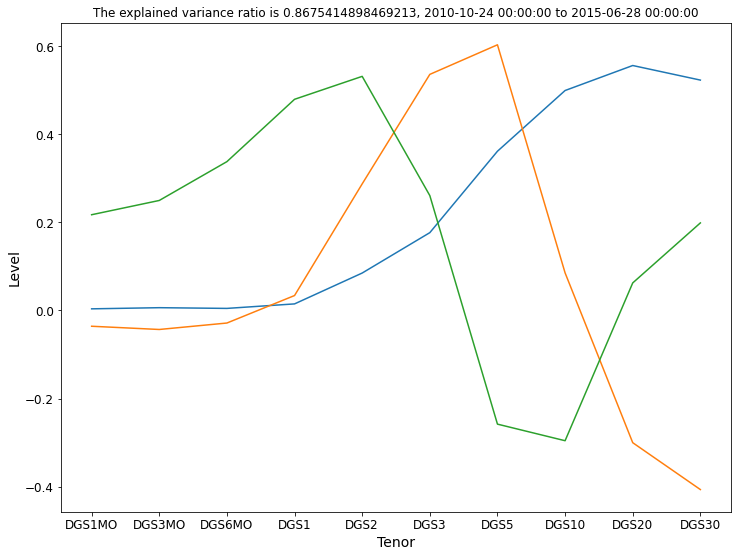

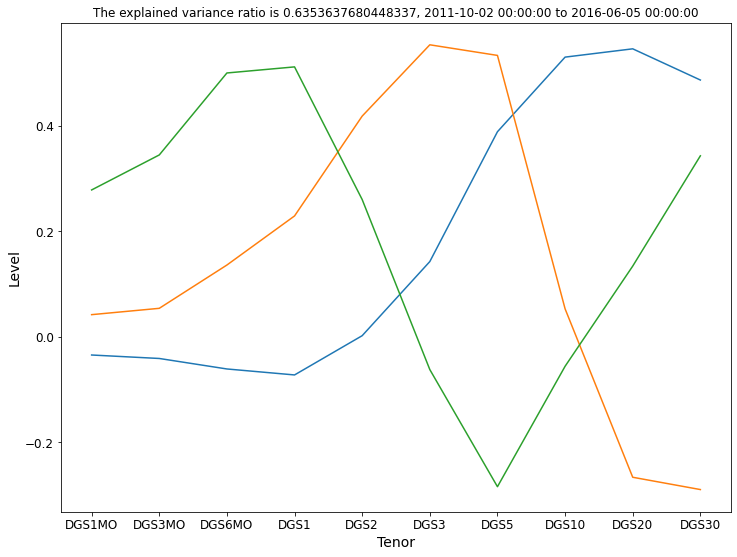

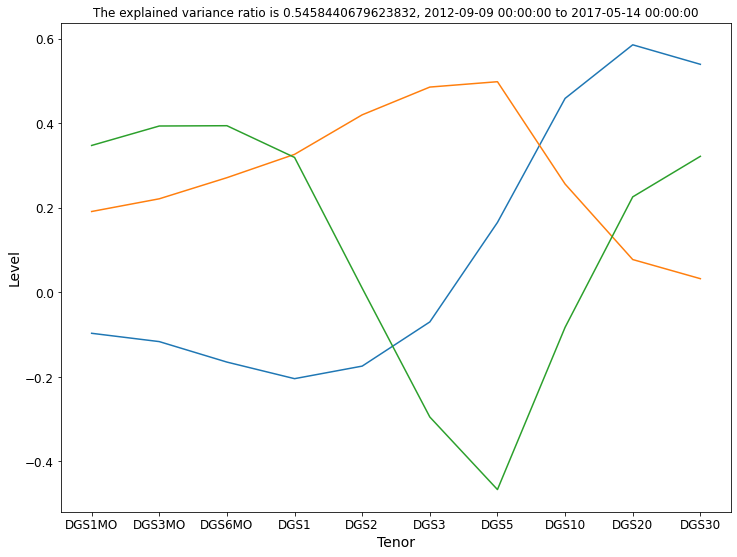

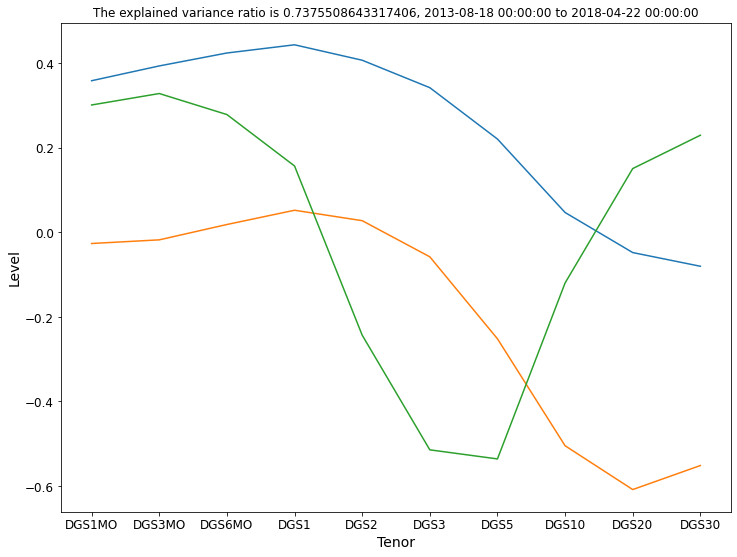

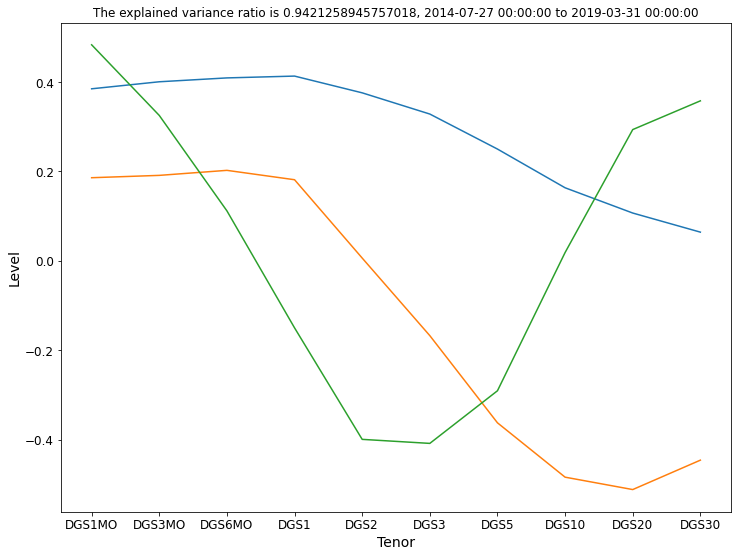

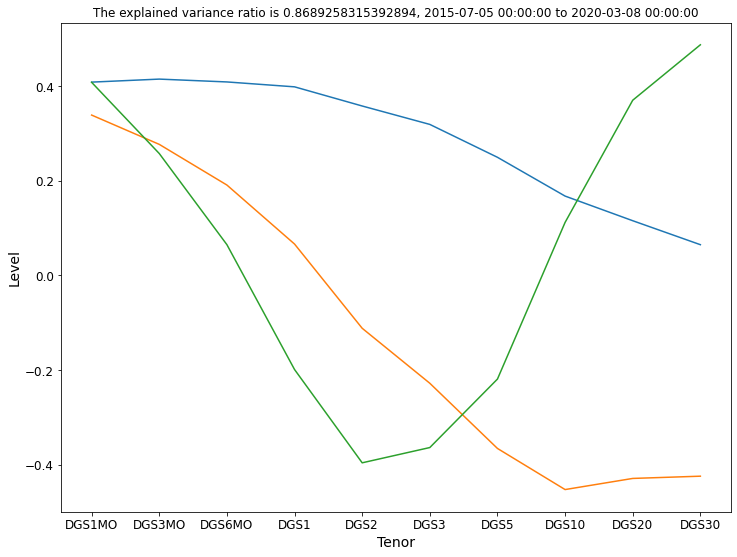

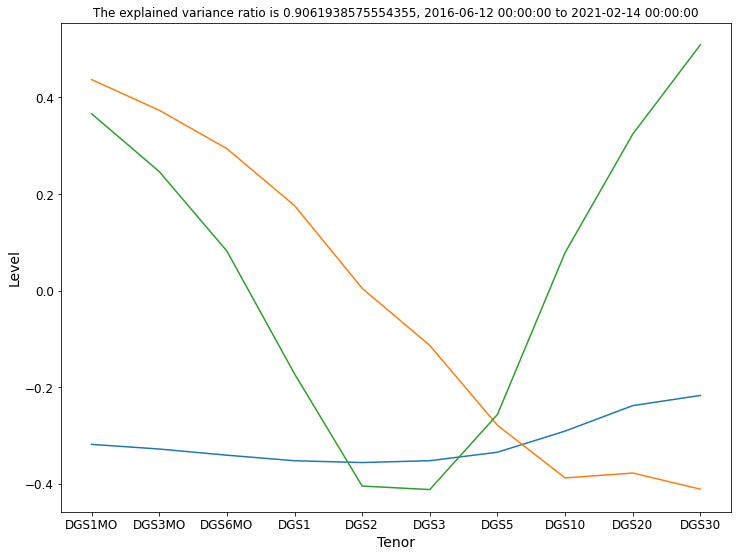

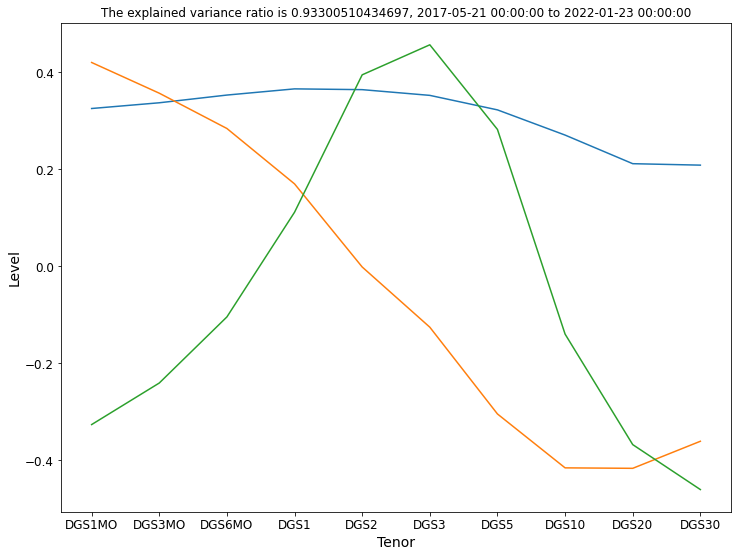

In [683]:
optimal_model_pipeline = Pipeline([
            # RolledTimeSeriesSplit for Cross-Validation
            ('RolledTimeSeriesSplit', RolledTimeSeriesSplit(n_splits=22, train_test_ratio=5)),  
            # MyPCA
            ('MyPCA', MyPCA(n_components=3, plot=True))      
        ])
_ = optimal_model_pipeline.fit_transform(resampled_aggregated_rates)